# Comparison on various methods

$$
\begin{cases}
x'=-\frac{1}{2}x-2y\\
y'=2x-\frac{1}{2}y\\
z'=-\frac{1}{5} z
\end{cases}
$$

This will rotate on the $xy$ plane and decrease on the $z$ axis. Origin is attracting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
import scienceplots
plt.style.use(["science", "notebook", "grid"])

In [2]:
def spiral3d(t, x):
    return [-0.5 * x[0] - 2 * x[1], 2 * x[0] - 0.5 * x[1], -0.2 * x[2]]

delta_t = 0.01
t = np.arange(0, 15, delta_t)
x0 = [1, 1, 0.5]
data = solve_ivp(spiral3d, (t[0], t[-1]), x0, t_eval=t, rtol = 1e-12, method = "LSODA", atol = 1e-12).y.T
data_derivative = np.array([spiral3d(0, data[t]) for t in range(t.size)])

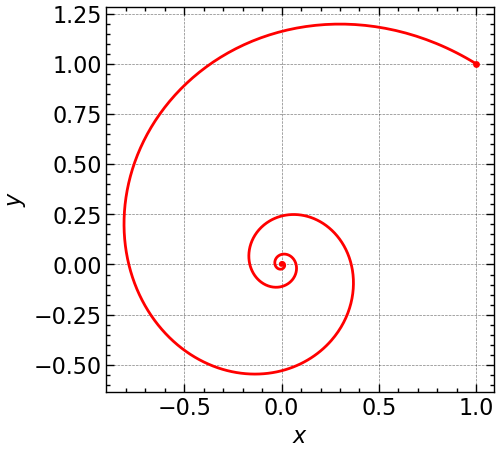

In [3]:
plt.figure(figsize=(5, 5))
plt.plot(data[:, 0], data[:, 1], c = "r")
plt.scatter(x0[0], x0[1], c = "r", s = 15)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

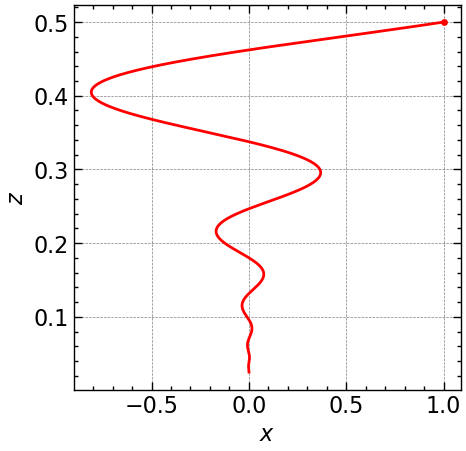

In [4]:
plt.figure(figsize=(5, 5))
plt.plot(data[:, 0], data[:, 2], c = "r")
plt.scatter(x0[0], x0[2], c = "r", s = 15)
plt.xlabel("$x$")
plt.ylabel("$z$")
plt.show()

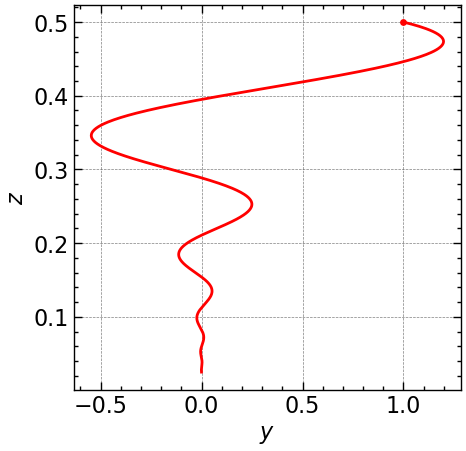

In [5]:
plt.figure(figsize=(5, 5))
plt.plot(data[:, 1], data[:, 2], c = "r")
plt.scatter(x0[1], x0[2], c = "r", s = 15)
plt.xlabel("$y$")
plt.ylabel("$z$")
plt.show()

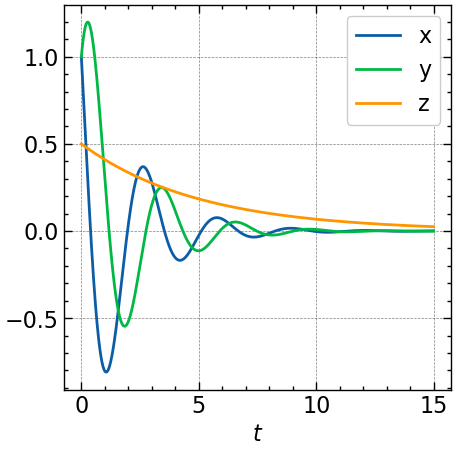

In [6]:
plt.figure(figsize=(5, 5))
plt.plot(t, data[:, 0], label = "x")
plt.plot(t, data[:, 1], label = "y")
plt.plot(t, data[:, 2], label = "z")
plt.xlabel("$t$")
plt.legend()
plt.show()

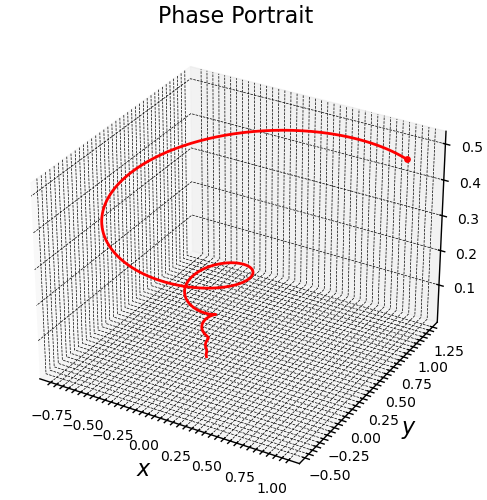

In [7]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:, 0], data[:, 1], data[:, 2], c="r")
ax.scatter(x0[0], x0[1], x0[2], c="r", s=15)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.zaxis.set_tick_params(labelsize=10)
ax.set_title("Phase Portrait")
plt.show()

In [8]:
models = {}
models_sim = {}
models_score = {}
lib = ps.PolynomialLibrary(2)
feat_names = ["x", "y", "z"]
opts = {"STLSQ": ps.STLSQ(), # alpha is regularization parameter
        "SR3": ps.SR3(),
        "LASSO": Lasso(),
        "RIDGE": Ridge(),
        "ELASTIC NET": ElasticNet()}

for opt_key, opt in opts.items():
    model = ps.SINDy(optimizer=opt, feature_library=lib, differentiation_method=ps.FiniteDifference(), feature_names=feat_names)
    model.fit(data, t, data_derivative)
    models[opt_key] = model
    models_sim[opt_key] = model.simulate(x0, t)
    r2 = model.score(data, t, data_derivative, metric=r2_score)
    mse = model.score(data, t, data_derivative, metric=mean_squared_error)
    models_score[opt_key] = [r2, mse] 

In [9]:
for model_key, model in models.items():
    print(f"{model_key}:")
    model.print()

STLSQ:
(x)' = -0.500 x + -2.000 y
(y)' = 2.000 x + -0.500 y
(z)' = -0.200 z
SR3:
(x)' = -0.500 x + -2.000 y
(y)' = 2.000 x + -0.500 y
(z)' = -0.200 z
LASSO:
(x)' = -0.067
(y)' = -0.066
(z)' = -0.032
RIDGE:
(x)' = -0.500 x + -2.000 y
(y)' = 2.000 x + -0.500 y + -0.002
(z)' = -0.200 z + -0.003
ELASTIC NET:
(x)' = -0.067
(y)' = -0.066
(z)' = -0.032


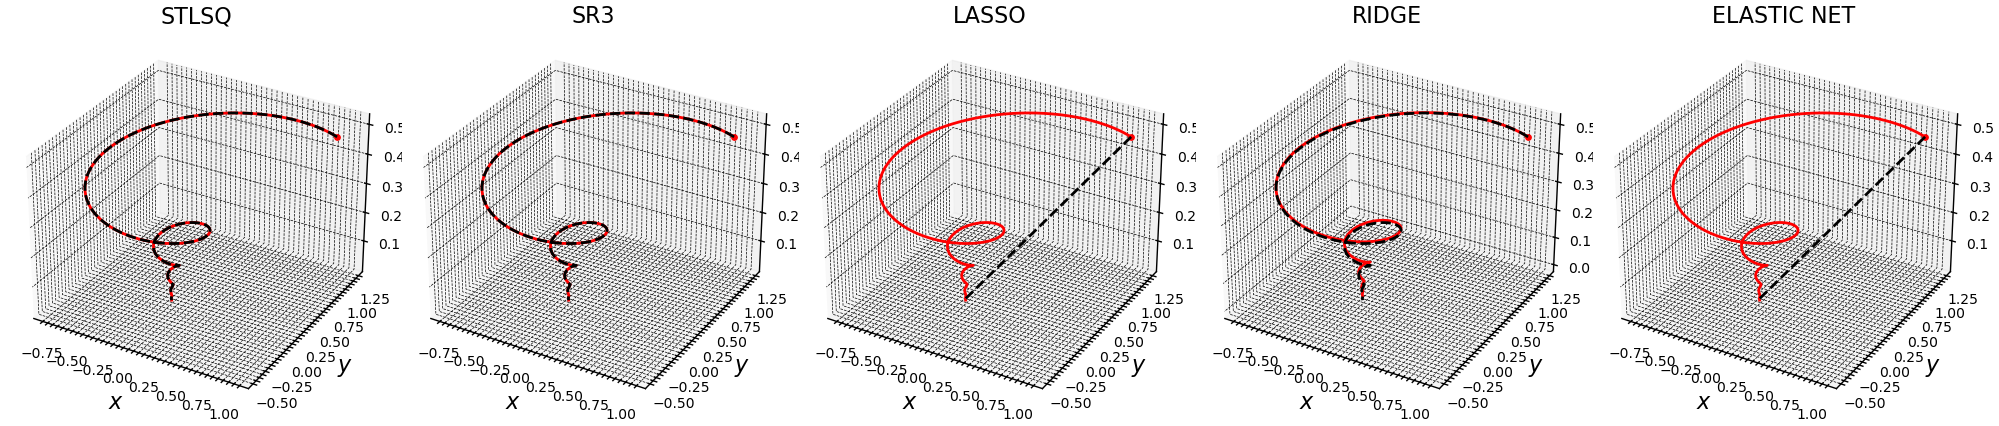

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, (model_key, model) in enumerate(models_sim.items()):
    ax = axs[i]
    ax.remove()
    ax = fig.add_subplot(1, 5, i + 1, projection='3d')
    ax.plot(data[:, 0], data[:, 1], data[:, 2], c="r", label="True")
    ax.plot(model[:, 0], model[:, 1], model[:, 2], "k--", label="SINDy")
    ax.scatter(x0[0], x0[1], x0[2], c="r", s=15)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$z$")
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.zaxis.set_tick_params(labelsize=10)
    ax.set_title(f"{model_key}")

# add legend
# handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2, prop={'size': 30})

plt.tight_layout()
plt.show()

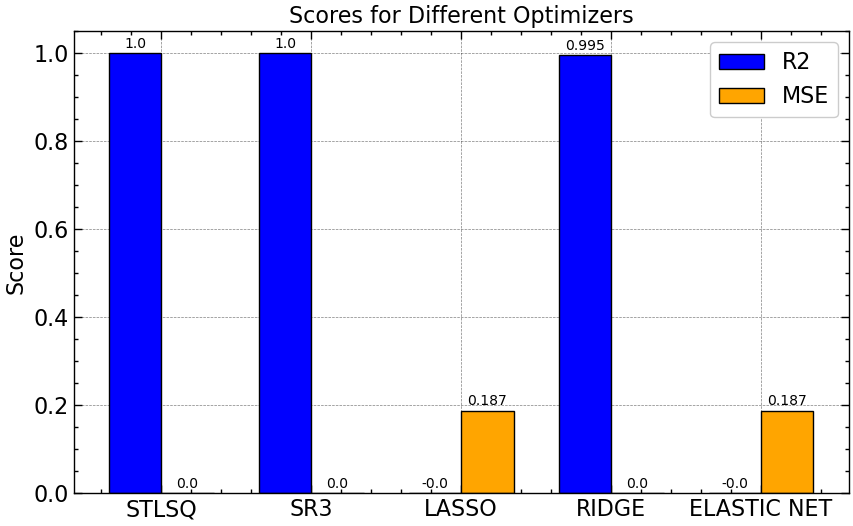

In [11]:
opts_key_list = list(models_score.keys())
r2_values = [score[0] for score in models_score.values()]
mse_values = [score[1] for score in models_score.values()]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(opts_key_list))

bar1 = ax.bar(index, r2_values, bar_width, label='R2', color='blue', edgecolor='black')
bar2 = ax.bar(index + bar_width, mse_values, bar_width, label='MSE', color='orange', edgecolor='black')
# ax.set_xlabel('Optimizers')
ax.set_ylabel('Score')
ax.set_title('Scores for Different Optimizers')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(opts_key_list)
ax.legend()

def autolabel(bars):
    # label on top of bar
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{round(height, 3)}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(bar1)
autolabel(bar2)
plt.show()